# Imports and parameters

## Set paths

In [1]:
# Model folder
model_path = '/Users/stepandenisov/Downloads/Brickplot_from_seq/Thermoters-master/'
# Fasta file with sequences
input_fasta_filepath = '/Users/stepandenisov/Downloads/Brickplot_from_seq/Input/v1.fasta'
# Output folder
output_folder = '/Users/stepandenisov/Downloads/Brickplot_from_seq/Output/'

In [2]:
import os
os.chdir(model_path + 'functions/')

print(os.getcwd())

/Users/stepandenisov/Downloads/Brickplot_from_seq/Thermoters-master/functions


In [3]:
%%file setup.py
from setuptools import setup
from Cython.Build import cythonize
import numpy as np
import os

print(np.get_include())

os.environ["C_INCLUDE_PATH"] = np.get_include()
setup(
    ext_modules = cythonize(model_path +'functions/fastFunctions.pyx')
)



Overwriting setup.py


In [4]:
print(os.getcwd())

/Users/stepandenisov/Downloads/Brickplot_from_seq/Thermoters-master/functions


## Import modules
### Usual modules

In [5]:
from Bio import SeqIO
from Bio.Seq import Seq
from __future__ import division, print_function, absolute_import
import os
import numpy as np
import copy
from sys import path as syspath
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn import linear_model

### Model-related imports

The most CPU intensive functions are in `fastFunctions.pyx`. It is a cython file that needs to be compiled. See <a href=https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html>cython tutorial </a> on how to do it. Upon successful compilation you get an `.so` file. I've put the one I obtained in the folder to be able to do show you this, but I doubt it will work for you. It probably needs to be recompiled for your system. If you need help, let me know.


In [6]:
os.chdir(model_path+'notebooks/')
os.getcwd()
syspath.append(model_path+'data/')
syspath.append(model_path+'functions/')

from fastFunctions import bindingEnergies, getDiNu, tensum

# this imports the data and functions from definitions
#exec(open(model_path+"functions/definitions_bigfit_10.py").read())
exec(open(model_path+"functions/definitions_bigfit_10.py_deprecated").read())

## Set constants & parameters
### Constants

In [7]:
bases = "acgt"
lett_to_index = dict(zip(bases, range(4)))

## Display options (adjusted to Mac)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Set parameters

In [8]:
is_plus_one = True # True - a brick points to +1; False - points to -40
if is_plus_one: # shift for sequence to adjust +1 or -40
    shift = 40
else:
    shift = 0
    
is_reverse_complement = False # If True, reverse complement fasta seqs, then treat as usual

# For visualisation

max_value = -2.5
min_value = -6

is_high_to_default = False # If True, visualize brickplot values > treshold as default value
treshold = -2.5
default_value = max_value 
color_map = 'hot'

is_prefix_suffix = True # True - add Gs to the begining and end of each sequence to make it equal length and space for matrix


# Preprocessing
Not a bug but the feature: add artificial 'g's in the begining and the end of all sequences to make them equal by length

In [9]:
# Import promoters seqs data
fasta_reader = open(input_fasta_filepath, 'r')

# Initial sequences: fasta -> dict
dict_seqs = {}
max_seq_len = 0
for line in fasta_reader:
    if line.startswith('>'):
        seq_id = line.strip('>').strip()
        print(seq_id)
    else:
        seq = line.strip('"').strip()
        if seq == '':
            continue
        else:
            if is_reverse_complement:
                seq = str(Seq(seq).reverse_complement())
        print('sequence length = '+str(len(seq)))
        if max_seq_len < len(seq):
            max_seq_len = len(seq)
        print(seq)
        dict_seqs[seq_id] = seq
        
fasta_reader.close()

# Sequences unified by length (TO MODIFY?)
# Add artificial 'g's in the begining and the end of all sequences to mak ethem equal by length
unified_seqs_dict = {}
for seq_id in dict_seqs:
    seq = dict_seqs[seq_id]
    if is_prefix_suffix:
        prefix = str('g'*(max_seq_len - len(seq)+shift+5))
        suffix = str('g'*(32+2+shift))
        unified_seqs_dict[seq_id] = (prefix+seq+suffix).lower()
    else:
        unified_seqs_dict[seq_id] = seq.lower()
        
    #print(len(unified_seqs_dict[seq_id]))
        
# Seqs as numbers: 1) list of Int arrays made from Sequences unified by length, 2) list of seq_ids     
num_unified_seqs = []
seq_ids = []
for seq_id in unified_seqs_dict:
    seq_ids.append(seq_id)
    
num_unified_seqs = np.array([np.array([lett_to_index[l] for l in s]) for s in unified_seqs_dict.values()])    


v1
sequence length = 291
CGCCAGCAACCGCACCTGTGGCGCCGGTGATGCCGGCCACGATGCGTCCGGCGTAGAGGATCTGCTCATGTTTGACAGCTTATCATCGATAGCTAACAATTCGTTCAAGCCGAGCCCGCTTTGCGGTCTCGGACCGACCGGAGCCGCATCGGGCGGGCCGGCTTAACTCAGGCGTTAGGTTTGCATAAAATTTACGGTTCTAGGGTTTATGCTGAGAGAAGAGAGAGGCGAGCCTGCTGTTATGATACTTGTGAAGGGCGGCACTCTGTCGTCTAATTCTAGTTAGACATC


# Import the model

In [10]:
# Import the model
dmp_path = model_path + "models/fitted_on_Pr.Pl.36N/model_[2]_stm+flex+cumul.dmp"
print(dmp_path)
with open(dmp_path,"rb") as f:
    model = pickle.load(f, encoding="latin1")

/Users/stepandenisov/Downloads/Brickplot_from_seq/Thermoters-master/models/fitted_on_Pr.Pl.36N/model_[2]_stm+flex+cumul.dmp


/Users/stepandenisov/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


I coded the model as a dictionary, but many of the keys are not important. I'll highlight only those that are.

In [11]:
leftFoot, rightFoot = model["matrices"]
defaultSpacer       = model["Layout"][1]
spacerFlexibility   = model["spFlex"]
spacerPenalties     = model["sp.penalties"]

# the total footprint of RNAp
print('The total footprint of RNAp = '+str(sum(model["Layout"])))

The total footprint of RNAp = 32


For example, here is the binding matrix

In [12]:
matrix = np.vstack([
    leftFoot,
    np.ones((defaultSpacer,4))*np.nan,
    rightFoot
])

print('The matrix size = '+str(matrix.shape))

The matrix size = (32, 4)


The matrix itself:


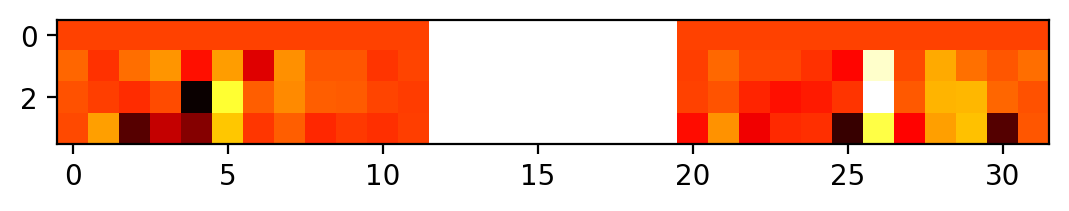

In [13]:
plt.imshow(matrix.T, cmap=color_map);
print('The matrix itself:')

To go from sequence to expression, there are a few steps:

# From sequence to expression
## Brickplots
### Get the bricks (apply the model to our seqs)

In [14]:
bricks = getBricks(
    twoMatrices     = [leftFoot,rightFoot],
    minSpacer       = defaultSpacer-spacerFlexibility, # minimal spacer
    spacerPenalties = spacerPenalties,
    sequences       = num_unified_seqs
)

# Default spacer corresponds to spacer flex = 0 on a brickplot
print('defaultSpacer = '+str(defaultSpacer))


defaultSpacer = 8


### Draw brickpolots

gggggcgccagcaaccgcacctgtggcgccggtgatgccggccacgatgcgtccggcgtagaggatctgctcatgtttgacagcttatcatcgatagctaacaattcgttcaagccgagcccgctttgcggtctcggaccgaccggagccgcatcgggcgggccggcttaactcaggcgttaggtttgcataaaatttacggttctagggtttatgctgagagaagagagaggcgagcctgctgttatgatacttgtgaagggcggcactctgtcgtctaattctagttagacatcggggggggggggggggggggggggggggggggggggggggg

extended seg_len = 337


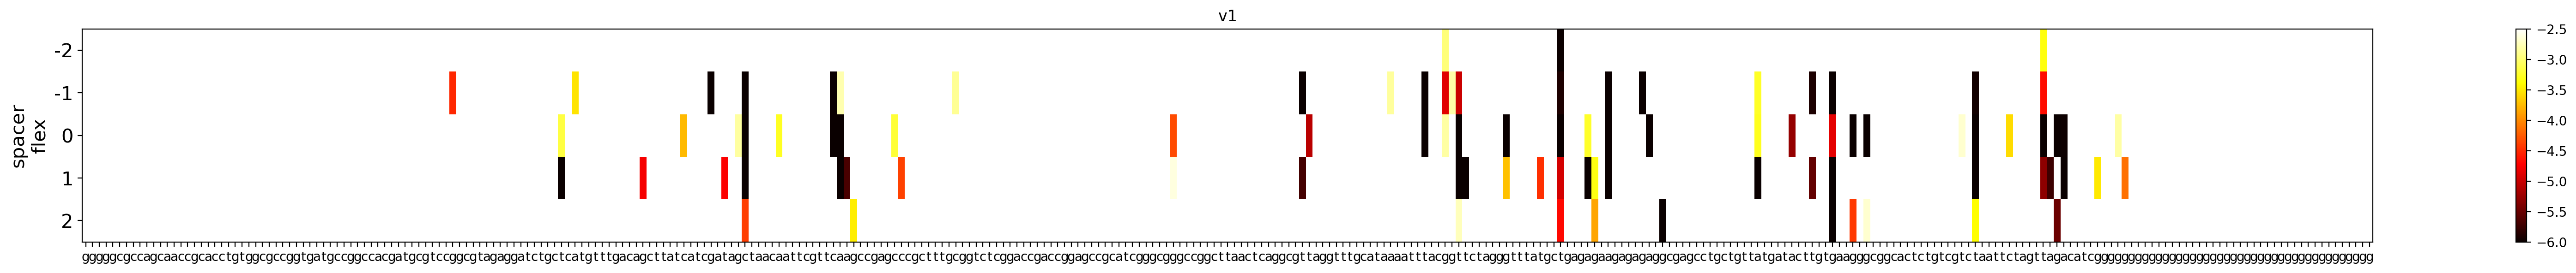

In [15]:
def remove_high_values(brick_in, treshold, default_value):
# Make values > treshold to be default value (for better visualization)
    brick_out = copy.deepcopy(brick_in)
    for i in range(brick_in.shape[0]):
        for j in range(brick_in.shape[1]):
            if brick_in[i,j] > treshold:
                brick_out[i,j] = default_value
    return brick_out
                
for i in range(len(num_unified_seqs)):
    curr_seq = unified_seqs_dict[seq_ids[i]][shift:-matrix.shape[0]-1]
    print(curr_seq)
    print('')
    print('extended seg_len = '+str(len(curr_seq)))
    theBrick = bricks.T[i]
    
    if is_high_to_default:
        theBrick_to_display = remove_high_values(theBrick, treshold, default_value)
    else:
        theBrick_to_display = theBrick

    plt.figure(figsize=(40,3))
    plt.imshow(theBrick_to_display.T[:,:theBrick_to_display.shape[0]-shift+1], cmap=color_map)
    plt.title(seq_ids[i])
    plt.yticks(range(5), np.arange(5)-2, fontsize=15)
    plt.xticks(range(len(curr_seq)), [char for char in curr_seq], fontsize=10)
    plt.clim([min_value,max_value])
    plt.ylabel('spacer\nflex', fontsize=15)
    plt.gca().set_aspect("auto")
    plt.colorbar()
    plt.savefig(output_folder+seq_ids[i]+'.pdf') 
    


They are binding energies per spacer per position.

What does a position mean? 
* trancription start site (+1) IF is_plus_one == True
* -40 which is begining of -35 sigma70 foot IF is_plus_one == False

The minimal value corresponds to the best binding.

## Bricks to $\log P_{\rm on}$

Our measure of expression is the $\log P_{\rm on}$, where $P_{\rm on}$ is the probability that the promoter is "on".

In [19]:
def brick2lps(bricks_DNIs,
              fitpars,
              thresholdPosDict_ = None,
              bindMode_ = None,
              useChemPot = "chem.pot"
             ):
    
    out = {}               
    if thresholdPosDict_ is None: # No threshold position given
        thresholdPosDict_ = fitpars["ThDict"]
    if bindMode_ is None: # No bindMode given
        bindMode_ = fitpars["bindMode"]
    
    # Try to get clearance rate
    try:
        R_ = np.exp(fitpars["logClearanceRate"])
    except:
        R_ = None
    
    # Loop over bricks
    for dataID_ in bricks_DNIs:
        if "_rc" in dataID_: # Skip reverse complement?
            continue
        
        # Get binding energies
        bdni = bricks_DNIs[dataID_]
       
        # Get threshold position
        try:
            thresholdPos = thresholdPosDict_.get(dataID_, thresholdPosDict_["Prl"])
        except:
            for k in thresholdPosDict_:
                if dataID_ in k:
                    thresholdPos = thresholdPosDict_[k]
                    break
        if thresholdPos <= 0:
            thresholdPos = bdni.shape[1] + thresholdPos
        # If the bricks d n i
        off = thresholdPos < bdni.shape[1]
    
        # Handle bind mode
        if bindMode_ == "add":
            if R_ is None:
                bindF = lambda xi: -logsumexp(-xi, axis = tuple(range(1, xi.ndim)))
            else:
                bindF = lambda xi: -np.log(np.sum(
                                    1.0/(np.exp(xi) + R_),
                                    axis = tuple(range(1,xi.ndim))
                                            ))
        elif bindMode_ == "max":
            bindF = lambda xi: np.min(xi, axis = tuple(range(1, xi.ndim)))
        
        # 
        effON_ = bindF(bdni[:, :thresholdPos])
        if off:
            effOFF_ = bindF(bdni[:, thresholdPos:])
        else:
            effOFF_ = 0.
  # Reverse complement
        if dataID_ + "_rc" in bricks_DNIs:
            bdni_rc = bricks_DNIs[dataID_ + "_rc"]
            rcOcclusion = fitpars.get("rcOcclusion", np.arange(bdni_rc.shape[1]))
            effOFF_ += bindF(bdni_rc[:, rcOcclusion])
        Pons_ = np.exp(-effON_) / (1.0 + np.exp(-effON_) + np.exp(-effOFF_))
        out[dataID_] = np.log10(Pons_)
    
    return out

In [20]:
#print(bricks.T)
print(bricks.T.shape)
print((model["chem.pot"]))
chemPot = model["chem.pot"]["Pr.Pl"]
energyScale = model["en.scale"]
logPons = brick2lps({"Pr": energyScale*(bricks.T-chemPot)}, model)["Pr"]
print(type(logPons))
print('log(Pon) = '+str(logPons))
print('Pon = '+ str(10**logPons))

(1, 376, 5)
{'Pr.Pl': -17.908525893586578, '36N': -18.51051925714286}
<class 'numpy.ndarray'>
log(Pon) = [-0.47883907]
Pon = [0.33201746]
